TODO : generaliser à images 32x32, etc.

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32

In [6]:
from scipy.stats import multivariate_normal

In [7]:
import math

In [8]:
import sys, os

In [9]:
import pickle

In [10]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [11]:
def mnist_reshape_32_buf(x):
    assert x.shape == (28 * 28,)
    image = x.reshape(28,28)
    image = np.append(np.zeros((2,28)), image, axis = 0)
    image = np.append(image, np.zeros((2,28)), axis = 0)
    image = np.append(np.zeros((32,2)), image, axis = 1)
    image = np.append(image, np.zeros((32,2)), axis = 1)
    return image



## Creation de la base d'apprentissage

In [12]:
if not os.path.isfile("mnist-waveimage-train-mu-Sigma-rho.pkl"):
    
    B_train = []
    for i in range(len(mnist.train.images)):
        if i % 1000 == 0 :
            sys.stdout.write('\rstep %d' % i) 
            sys.stdout.flush()
        c = mnist.train.labels[i]
        image = mnist_reshape_32(mnist.train.images[i])
        w = WaveImage(image = image)
        data = w.get_data()
        for h in range(w.get_h_max()):
            data_h = w.get_data()[h]
            for u in data_h:
                v = data_h[u]
                B_train += [(v,(c,h,u))]   
                
    ### Dictionnaire (Base d'apprentissage)    
    
    Data_train = [[],[],[],[],[],[],[],[],[],[]]
    for c in range(10):
        Data_train[c] = [{},{},{},{},{},{}] 

    for d in B_train:
        v = d[0]
        c = d[1][0]
        h = d[1][1]
        u = d[1][2]
        if u in Data_train[c][h]:
            Data_train[c][h][u] += [v]
        else:
            Data_train[c][h][u] = [v]
            
    ### Probas elementaires         
    mu = []
    Sigma = []
    rho = []
    for c in range(10):
        mu += [{}]
        Sigma += [{}]
        rho += [{}]
        for h in range(0,6):
            mu[c][h] = {}
            Sigma[c][h] = {}
            rho[c][h] = {}
            for u in calc_U((32, 32), h, 6):
                if u in Data_train[c][h]:
                    data = []
                    cpt = 0
                    for v in Data_train[c][h][u]:
                        if np.linalg.norm(v) < 1e-16:
                            cpt += 1
                        else:
                            data += [v]
                    #if h == -1 :
                    #    print len(data)
                    if len(data) > 1:
                        mu[c][h][u] = np.mean(data, 0) #Data[c][h][u],0)
                        Sigma[c][h][u] = np.cov(np.array(data).T) #Data[c][h][u]).T)
                        rho[c][h][u] = float(cpt) / len(Data_train[c][h][u])
                    else:
                        mu[c][h][u] = np.zeros(3)
                        Sigma[c][h][u] = np.zeros((3,3))
                        rho[c][h][u] = 1.
    del B_train, Data_train 
    pickle.dump((mu, Sigma, rho),  open("mnist-waveimage-train-mu-Sigma-rho.pkl", "wb"))
else:
    mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho.pkl", "rb"))

nb_pos = 1 + 1 * 1 + 2 * 2 + 4 * 4 + 8 * 8 + 16 * 16
print "# weak classifiers (# pos):", nb_pos
print "# total examples :", len(B_train)
print "# total examples / weak classifier :", len(B_train) / nb_pos

# weak classifiers (# pos): 342
# total examples : 18810000
# total examples / weak classifier : 55000

## Base de test

In [13]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [14]:
if not os.path.isfile("mnist-waveimage-test-data.pkl"):
    B_test = []
    for i in range(len(mnist.test.images)):
        if i % 1000 == 0 :
            sys.stdout.write('\rstep %d' % i) 
            sys.stdout.flush()
        c = mnist.test.labels[i]
        image = mnist_reshape_32(mnist.test.images[i])
        w = WaveImage(image = image)
        data = w.get_data()
        for h in range(w.get_h_max()):
            data_h = w.get_data()[h]
            for u in data_h:
                v = data_h[u]
                B_test += [(v,(c,h,u))]    
                
    Data_test = [[],[],[],[],[],[],[],[],[],[]]
    for c in range(10):
        Data_test[c] = [{},{},{},{},{},{}] 

    for d in B_test:
        v = d[0]
        c = d[1][0]
        h = d[1][1]
        u = d[1][2]
        if u in Data_test[c][h]:
            Data_test[c][h][u] += [v]
        else:
            Data_test[c][h][u] = [v]
    del B_test, Data_test
    pickle.dump(Data_test,  open("mnist-waveimage-test-data.pkl", "wb"))
else:
    Data_test = pickle.load(open("mnist-waveimage-test-data.pkl", "rb"))            

# Construction du réseau

In [15]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [16]:
def wave_tensor_flat(batch_x):
    batch_size, _ = batch_x.shape
    wave_tensor = np.zeros((batch_size, (16 * 16 + 8 * 8 + 4 * 4 + 2 * 2 + 1) * 3 + 1))
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        for h in range(w.get_h_max()):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[num_batch][0] = data_h[(0,0)]
                i_ref = 1
            else:
                for u in data_h:
                    i_ref = 1
                    for h_ in range(1, h):
                        i_ref += 3 * ((2**(h_-1))**2)
                    width_ref = 2**(h-1)
                    i_ref += u[0] * width_ref * 3 + u[1] * 3
                    wave_tensor[num_batch][i_ref:i_ref + 3] = data_h[u]
                    #wave_tensor[num_batch][i_ref:i_ref + 3] = data_h[u]
                    #i_ref += 3
    return wave_tensor

In [17]:
def init_test_tensor(BATCH_SIZE = 1):
    return np.zeros((BATCH_SIZE, (16 * 16 + 8 * 8 + 4 * 4 + 2 * 2 + 1) * 3 + 1))

In [18]:
def fill_test_tensor(v, h, u, test_tensor, BATCH_SIZE = 1):
    if h == 0:
        test_tensor[0][0] = v
    else:
        i_ref = 1
        for h_ in range(1, h):
            i_ref += 3 * ((2**(h_-1))**2)
        width_ref = 2**(h-1)
        i_ref += u[0] * width_ref * 3 + u[1] * 3
        test_tensor[0][i_ref:i_ref + 3] = v

h = 1
i_ref = 1
for h_ in range(1, h):
    i_ref += 3 * ((2**(h_-1))**2)
width_ref = 2**(h-1)
i_ref += u[0] * width_ref * 3 + u[1] * 3
print width_ref

In [19]:
def copy_test_tensor(test_tensor):
    return np.copy(test_tensor)

In [23]:
class Obj:
    pass

In [24]:
params = Obj()
params.batch_size = 100

In [25]:
batch = mnist.train.next_batch(params.batch_size)
wave_tensor = wave_tensor_flat(batch[0])

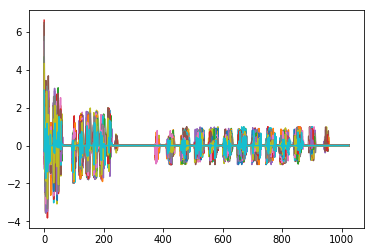

In [26]:
_ = plt.plot(wave_tensor.T)

Construction 


In [27]:
DEPTH_WAV = 3
DIM_WAV = (16 * 16 + 8 * 8 + 4 * 4 + 2 * 2 + 1) * 3 + 1
DIM_HIDDEN = 512
NB_LABEL = 10
STD = 1. #1e-5

In [28]:
def weight_variable(shape, stddev = 0.1, name = "dummy"):
    #initial = tf.truncated_normal(shape, stddev=0.1)
    #print stddev
    initial = tf.random_normal(shape, stddev = stddev)
    #initial = tf.zeros(shape)
    return tf.Variable(initial, name = name)

### placeholders

In [29]:
x = tf.placeholder(tf.float32, shape=[None, DIM_WAV])
y = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)
#batch_phase = tf.placeholder(tf.bool, name='bn_phase')

### Layers

In [30]:
# Paramètres
W_input_hidden1 = weight_variable([DIM_WAV, DIM_HIDDEN], \
                            stddev = STD / DIM_WAV, \
                            name = "W_input_hidden1")
# Graph construction
h_hidden1 = tf.matmul(x, W_input_hidden1, name = 'h_hidden1')
z_hidden1 = tf.nn.relu(h_hidden1)
z_hidden1_drop = tf.nn.dropout(z_hidden1, keep_prob)


# Paramètres
W_hidden1_hidden2 = weight_variable([DIM_HIDDEN, DIM_HIDDEN], \
                            stddev = STD / DIM_HIDDEN, \
                            name = "W_hidden1_hidden2")
# Graph construction
h_hidden2 = tf.matmul(z_hidden1_drop, W_hidden1_hidden2, name = 'h_hidden2')
z_hidden2 = tf.nn.relu(h_hidden2)
z_hidden2_drop = tf.nn.dropout(z_hidden2, keep_prob)

# Paramètres
W_hidden2_out = weight_variable([DIM_HIDDEN, NB_LABEL], \
                            stddev = STD / DIM_HIDDEN, \
                            name = "W_hidden2_out")
# Graph construction
h_out = tf.matmul(z_hidden2_drop, W_hidden2_out, name = 'h_out')

### Loss graph¶

In [31]:
classif_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=h_out))
sigmoid_loss = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=h_out), reduction_indices=1))
#KL_loss = -tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.nn.softmax(h_out), logits=h_out))
KL_loss = tf.reduce_mean(tf.log(NB_LABEL * 1.) + tf.reduce_sum(tf.nn.softmax(h_out) * tf.log(tf.nn.softmax(h_out)), reduction_indices=1) )

### Train graph¶

In [32]:
train = tf.train.AdamOptimizer(1e-4).minimize(classif_loss) # + KL_loss)

### Evaluation graph

In [33]:
correct_prediction = tf.equal(tf.argmax(h_out, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Training session

In [34]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [35]:
mem = Obj()
mem.num_epoch = []
mem.classif_eval = []
params.n_epochs = 100000

In [36]:
file_name = "models/mnist-waveimage-FCNN-512"

if not os.path.isfile(file_name + ".ckpt.index"):
    for num_epoch in range (params.n_epochs):
        if num_epoch % 10 == 0:
            mem.num_epoch += [num_epoch]
            x_test, y_test = mnist.test.next_batch(params.batch_size)
            wave_tensor = wave_tensor_flat(x_test)
            classif_eval = accuracy.eval(feed_dict={x: wave_tensor,\
                                                    y: y_test,\
                                                    keep_prob: 1})
                                                    #batch_phase:False})
            mem.classif_eval += [classif_eval]
            sys.stdout.write('\rstep %d\t classif : %.5f' \
                             % (num_epoch, \
                                classif_eval))
            if num_epoch % 1000 == 0:
                saver.save(sess,          file_name + ".ckpt")
                pickle.dump(mem,     open(file_name + "_mem.pkl", "wb"))

        batch_x, batch_y = mnist.train.next_batch(params.batch_size) 
        wave_tensor = wave_tensor_flat(batch_x)
        train.run(feed_dict={x: wave_tensor,\
                              y: batch_y,\
                              keep_prob: 1})
                              #batch_phase:True})
else:
    saver.restore(sess,       file_name + ".ckpt")
    mem    = pickle.load(open(file_name + "_mem.pkl", "rb"))

INFO:tensorflow:Restoring parameters from models/mnist-waveimage-FCNN-512.ckpt


In [33]:
x_test, y_test = mnist.test.images, mnist.test.labels
wave_tensor = wave_tensor_flat(x_test)
classif_eval = accuracy.eval(feed_dict={x: wave_tensor,\
                                        y: y_test,\
                                        keep_prob:1})
sys.stdout.write('\rclassif : %.5f' \
                 % (classif_eval,))

classif : 0.98180

In [36]:
sess.run(classif_loss, feed_dict={x: wave_tensor,\
                                                    y: y_test,\
                                                    keep_prob: 1})

0.80372351

In [37]:
sess.run(KL_loss, feed_dict={x: wave_tensor,\
                                                    y: y_test,\
                                                    keep_prob: 1})

0.43711787

In [38]:
sess.run(sigmoid_loss, feed_dict={x: wave_tensor,\
                                                    y: y_test,\
                                                    keep_prob: 1})

3.3869207

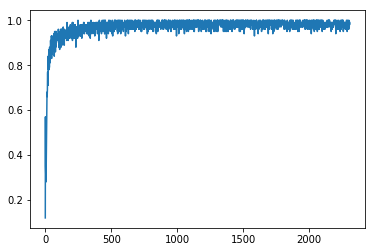

In [34]:
plt.plot(mem.classif_eval)

## Tests single prediction

In [43]:
test_tensor = np.zeros((1, DIM_WAV))

test = h_out.eval(feed_dict={x: test_tensor, keep_prob:1})

print test

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


[[-0.0066566  -0.00572316 -0.00381979 -0.01190897 -0.00598561  0.00114082
  -0.00667713  0.00680717 -0.01397626 -0.01786012]]


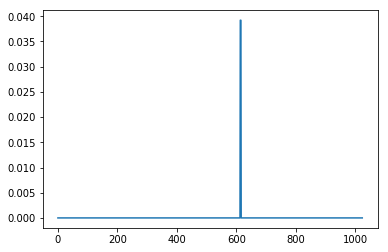

In [44]:
c = 0
ind_test = 0
u_test = (7, 7)
h_test = 5
v = Data_test[c][h_test][u_test][ind_test]

test_tensor = np.zeros((1, DIM_WAV))
y_test = np.zeros((1, 10))
y_test[0, c] = 1

fill_test_tensor(v, h_test, u_test, test_tensor)
test = h_out.eval(feed_dict={x: test_tensor, keep_prob:1})
print test
plt.plot(test_tensor[0])

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]] [[-1.12595606 -1.14728284 -1.14292693  1.13128233 -1.07892156 -1.17227411
  -0.91522253 -1.2751075  -1.12907171 -1.17660153]]
[[  1.13367289e-03   1.06341206e-03   1.07739912e-03   9.89478409e-01
    1.30547443e-03   9.86599247e-04   2.13328609e-03   7.24704238e-04
    1.12312601e-03   9.73873597e-04]]


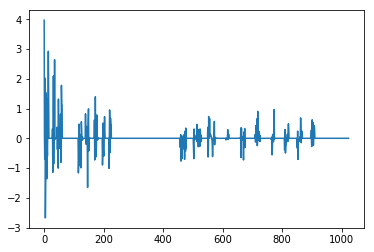

In [45]:
batch_test, c_test = mnist.test.next_batch(1)
test_tensor_full = wave_tensor_flat(batch_test)
test = h_out.eval(feed_dict={x: test_tensor_full, keep_prob:1})
print c_test, test
plt.plot(test_tensor_full[0])
print sess.run(tf.nn.softmax(test * 3))

[ 3.9671571   0.06299021 -0.70196083  2.02279425 -2.67549036 -1.53137264
  1.53137264 -1.35465694  1.35465694 -1.35465694]
[ 3.9671571   0.06299021 -0.70196083  2.02279425 -2.67549036 -1.53137264
  1.53137264 -1.35465694  1.35465694 -1.35465694]
(1024,) (1024,)


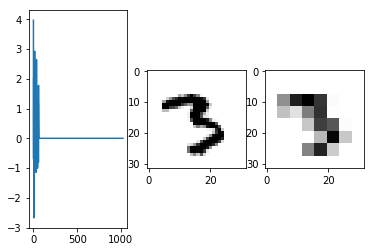

In [46]:
test_tensor_full = wave_tensor_flat(np.array((batch_test[0],)))
plt.plot(test_tensor_full[0])    

w_test = WaveImage(image = mnist_reshape_32(batch_test[0]))
w_zero = WaveImage()

test_tensor = np.zeros((1, (16 * 16 + 8 * 8 + 4 * 4 + 2 * 2 + 1) * 3 + 1))
image = mnist_reshape_32(batch_test[0])
w = WaveImage(image = image)
for h in range(4):
    data_h = w.get_data()[h]
    for u in data_h:
        fill_test_tensor(data_h[u], h, u, test_tensor)
        w_zero.set_data(h,u,data_h[u])

plt.subplot(1,3,1)        
plt.plot(test_tensor[0])        
plt.subplot(1,3,2)
plt.imshow(w_test.get_image(), interpolation='nearest', cmap='gray_r')
plt.subplot(1,3,3)
plt.imshow(w_zero.get_image(), interpolation='nearest', cmap='gray_r')

print test_tensor[0][0:10] 
print test_tensor_full[0][0:10]
print test_tensor[0].shape, test_tensor_full[0].shape


In [47]:
classif_loss.eval(feed_dict={x: test_tensor,\
                                y: y_test,\
                                keep_prob: 1})

2.5834126

In [48]:
y_test

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [49]:
classif_loss.eval(feed_dict={x: test_tensor_full,\
                                y: c_test,\
                                keep_prob: 1})

0.66404802

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]] [[ 0.07551584  0.08485645  0.08108424  0.23944736  0.07503367  0.0711219
   0.08710137  0.09868617  0.0884757   0.09867734]]


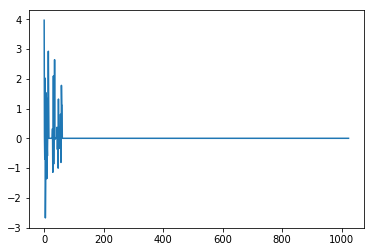

In [50]:
test = h_out.eval(feed_dict={x: test_tensor, keep_prob:1})
print c_test, sess.run(tf.nn.softmax(test))
plt.plot(test_tensor[0])

## Predictive model

#### Liste des coordonnées par niveau : U[h], h $\in$ 0..5

In [37]:
axes = []
h_max = 6
shape = (32,32)

'''for h in range(h_max):
    h_opp = 5 - h
    b_moins = -.5
    b_plus = 27.5
    intervalle = b_plus - b_moins
    coord_max = int(26.5 / 2**h_opp) + 1
    unite = max(intervalle / coord_max, 2**h_opp)
    print unite
    coords = []
    for j in range(coord_max):
        coords += [b_moins + (j+.5) * unite]
    axes += [coords]
print axes
print '''''

U = {}
for h in range(h_max):
    #U_ref = {}
    #for pos_i in axes[h]:
    #    for pos_j in axes[h]:
    #        U_ref[h] += [(pos_i, pos_j)]
    U [h] = {}
    dim_i, dim_j = calc_dim(shape, h, h_max)
    for i in range(dim_i):
        for j in range(dim_j):
            U[h][(i,j)] = 1    
    print 'Niveau ', h, ' : '
    print ' U[' , h, '] :', U[h]
    #print ' U_ref[h] :', U_ref[h]
    print ''
    


Niveau  0  : 
 U[ 0 ] : {(0, 0): 1}

Niveau  1  : 
 U[ 1 ] : {(0, 0): 1}

Niveau  2  : 
 U[ 2 ] : {(0, 1): 1, (1, 0): 1, (0, 0): 1, (1, 1): 1}

Niveau  3  : 
 U[ 3 ] : {(0, 1): 1, (1, 2): 1, (3, 2): 1, (0, 0): 1, (3, 3): 1, (3, 0): 1, (3, 1): 1, (2, 1): 1, (0, 2): 1, (2, 0): 1, (1, 3): 1, (2, 3): 1, (2, 2): 1, (1, 0): 1, (0, 3): 1, (1, 1): 1}

Niveau  4  : 
 U[ 4 ] : {(7, 3): 1, (4, 7): 1, (1, 3): 1, (6, 4): 1, (3, 0): 1, (5, 4): 1, (0, 7): 1, (5, 6): 1, (2, 6): 1, (1, 6): 1, (5, 1): 1, (3, 7): 1, (2, 5): 1, (0, 3): 1, (7, 2): 1, (4, 0): 1, (1, 2): 1, (6, 7): 1, (3, 3): 1, (2, 0): 1, (7, 6): 1, (4, 4): 1, (6, 3): 1, (1, 5): 1, (3, 6): 1, (2, 2): 1, (7, 7): 1, (5, 7): 1, (5, 3): 1, (4, 1): 1, (1, 1): 1, (2, 7): 1, (3, 2): 1, (0, 0): 1, (6, 6): 1, (5, 0): 1, (7, 1): 1, (4, 5): 1, (0, 4): 1, (5, 5): 1, (1, 4): 1, (6, 0): 1, (7, 5): 1, (2, 3): 1, (2, 1): 1, (4, 2): 1, (1, 0): 1, (6, 5): 1, (3, 5): 1, (0, 1): 1, (7, 0): 1, (4, 6): 1, (5, 2): 1, (6, 1): 1, (3, 1): 1, (0, 2): 1, (7, 4): 1, (0

#### Construction d'un arbre de coordonnées multi-niveau (descendants pour (i,j) au niveau h)

In [38]:
def fils_rec(shape, h, h_max, i, j):
    
    if h < h_max :
        dim_i, dim_j = calc_dim(shape, h, h_max)
        if i < dim_i and j < dim_j :
            rep = [(h,(i,j)), [], [], [], []]
            rep[1] = fils_rec(shape, h + 1, h_max, i * 2, j * 2)
            rep[2] = fils_rec(shape, h + 1, h_max, i * 2, j * 2 + 1)
            rep[3] = fils_rec(shape, h + 1, h_max, i * 2 + 1, j * 2)
            rep[4] = fils_rec(shape, h + 1, h_max, i * 2 + 1, j * 2 + 1)
        else:
            rep = []
    else:
        rep = []
    return rep
    


In [39]:
U_tree = fils_rec(shape, 0, h_max, 0, 0) 
print U_tree

[(0, (0, 0)), [(1, (0, 0)), [(2, (0, 0)), [(3, (0, 0)), [(4, (0, 0)), [(5, (0, 0)), [], [], [], []], [(5, (0, 1)), [], [], [], []], [(5, (1, 0)), [], [], [], []], [(5, (1, 1)), [], [], [], []]], [(4, (0, 1)), [(5, (0, 2)), [], [], [], []], [(5, (0, 3)), [], [], [], []], [(5, (1, 2)), [], [], [], []], [(5, (1, 3)), [], [], [], []]], [(4, (1, 0)), [(5, (2, 0)), [], [], [], []], [(5, (2, 1)), [], [], [], []], [(5, (3, 0)), [], [], [], []], [(5, (3, 1)), [], [], [], []]], [(4, (1, 1)), [(5, (2, 2)), [], [], [], []], [(5, (2, 3)), [], [], [], []], [(5, (3, 2)), [], [], [], []], [(5, (3, 3)), [], [], [], []]]], [(3, (0, 1)), [(4, (0, 2)), [(5, (0, 4)), [], [], [], []], [(5, (0, 5)), [], [], [], []], [(5, (1, 4)), [], [], [], []], [(5, (1, 5)), [], [], [], []]], [(4, (0, 3)), [(5, (0, 6)), [], [], [], []], [(5, (0, 7)), [], [], [], []], [(5, (1, 6)), [], [], [], []], [(5, (1, 7)), [], [], [], []]], [(4, (1, 2)), [(5, (2, 4)), [], [], [], []], [(5, (2, 5)), [], [], [], []], [(5, (3, 4)), [], [

#### Calcul des descendants et des parents

In [40]:
def calcule_desc(U_tree, mem_h_u_todo):
    if U_tree == []:
        return []
    else :
        if U_tree[0] in mem_h_u_todo :
            rep = [U_tree[0]]
        else:
            rep = []
        if U_tree[1] != [] :
            rep += calcule_desc(U_tree[1], mem_h_u_todo)
        if U_tree[2] != [] :
            rep += calcule_desc(U_tree[2], mem_h_u_todo)
        if U_tree[3] != [] :
            rep += calcule_desc(U_tree[3], mem_h_u_todo)
        if U_tree[4] != [] :
            rep += calcule_desc(U_tree[4], mem_h_u_todo)    
        return rep

In [41]:
print calcule_desc(U_tree, [(5, (5, 7)), (4, (2, 3))])

[(4, (2, 3)), (5, (5, 7))]


In [42]:
def find_desc (U_tree, (h, u)):
    if U_tree == []:
        return None
    else :    
        if U_tree[0] == (h, u) :
            return U_tree
        else:
            desc_1 = find_desc(U_tree[1], (h, u))
            if desc_1 != None:
                return desc_1
            desc_2 = find_desc(U_tree[2], (h, u))
            if desc_2 != None:
                return desc_2
            desc_3 = find_desc(U_tree[3], (h, u))
            if desc_3 != None:
                return desc_3
            desc_4 = find_desc(U_tree[4], (h, u))
            if desc_4 != None:
                return desc_4

In [43]:
print find_desc(U_tree, (4, (2, 3)))

[(4, (2, 3)), [(5, (4, 6)), [], [], [], []], [(5, (4, 7)), [], [], [], []], [(5, (5, 6)), [], [], [], []], [(5, (5, 7)), [], [], [], []]]


In [44]:
def calcule_asc_path(h,u):
    rep = []
    for h_inf in range(h, 0, -1):
        i_inf = u[0] / (2 ** (h - h_inf))
        j_inf = u[1] / (2 ** (h - h_inf))
        rep += [(h_inf, (i_inf, j_inf))]
    # racine
    rep += [(0, (i_inf, j_inf))]
    return rep

In [45]:
print calcule_asc_path(5,(15,3))

[(5, (15, 3)), (4, (7, 1)), (3, (3, 0)), (2, (1, 0)), (1, (0, 0)), (0, (0, 0))]


#### Utilitaires

### Reconstruction

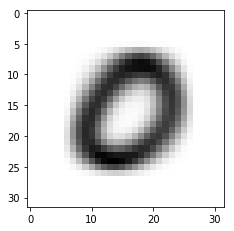

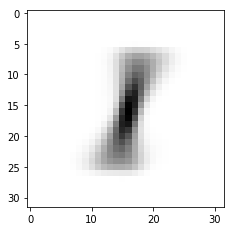

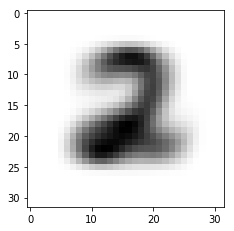

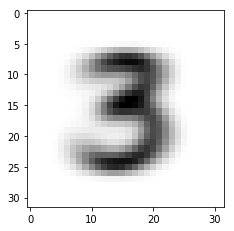

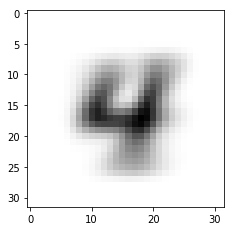

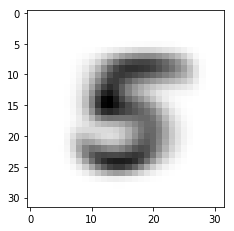

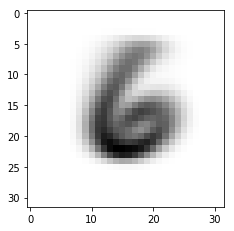

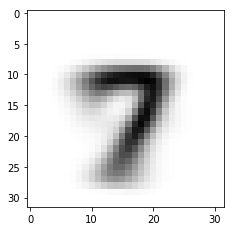

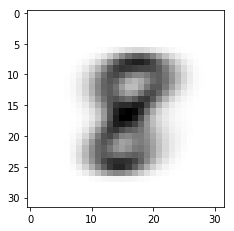

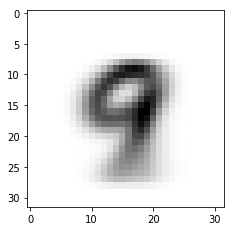

In [47]:
avg_image = {}
for c in range(10):
    w = WaveImage()
    for h in range(6):
        for u in calc_U((32, 32), h, 6):
            w.set_data( h, u, mu[c][h][u] * (1 - rho[c][h][u]))
    avg_image[c] = w.get_image()
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.imshow(w.get_image(), interpolation='nearest', cmap='gray_r')



#### !!!TODO!!! Posterior predictif : $q(.)|_{\tilde{z}, \text{u}}$ basé sur une liste de vues `liste_u`  

## Generative models

In [48]:
def argmax_generator(c, h, u):
    test_pred = rho[c][h][u] < .5       
    if test_pred:
        return mu[c][h][u]
    else:
        return np.zeros(3)

In [49]:
def monte_carlo_generator(c, h, u):
    if np.random.random() > rho[c][h][u]:
        return np.random.multivariate_normal(mu[c][h][u], Sigma[c][h][u], 1)[0]
    else:
        return np.zeros(3)

## Parcours predictif

In [50]:
def predictive_search(sess, z_ref, actions_set, mem_h_u, batch_ref = None):
    # actions_set ne contient que les positions de niveau 5
    h_ref = h_max - 1
    
    ## Parcours predictif
    batch_predictive_tensor = np.zeros((len(actions_set), DIM_WAV))
    dict_u = {}
    for i, u_gen in enumerate(actions_set):
        dict_u[i] = u_gen
        liste_path = calcule_asc_path(h_ref, u_gen)
        if batch_ref is not None:
            batch_predictive_tensor[i] = np.copy(batch_ref)
        for (h_path, u_path) in liste_path[:-1]:
            if (h_path, u_path) not in mem_h_u:
                v_predictive = argmax_generator(z_ref, h_path, u_path)
                fill_test_tensor(v_predictive, h_path, u_path, [batch_predictive_tensor[i]])

    log_score_path = sess.run(h_out, feed_dict={x: batch_predictive_tensor,\
                                                        keep_prob: 1})
    pi_path = sess.run(tf.nn.softmax(MULT_FACTOR * log_score_path))
    
    ## 3 ##
    i_max = np.where(pi_path[:, z_ref] == max(pi_path[:, z_ref]))[0][0]
    return dict_u[i_max], pi_path[i_max, z_ref]
    

## Saliency maps calculation

#### Basic saliency map : `pi_predictive[c][u]` (h = 5)

In [51]:
pi_predictive = {}
h_ref = h_max - 1

for c in range(10):
    print c
    pi_predictive[c] = {}

    actions_set = {}
    for u_add in U[h_ref]:
        actions_set[u_add] = 1
    
    batch_predictive_tensor = np.zeros((len(actions_set), DIM_WAV))
    dict_u = {}
    
    for i, u_gen in enumerate(actions_set):
        ##***
        #w_aff = WaveImage()

        dict_u[i] = u_gen
        liste_path = calcule_asc_path(h_ref, u_gen)
        for (h_path, u_path) in liste_path[:-1]:
            v_predictive = argmax_generator(c, h_path, u_path)
            fill_test_tensor(v_predictive, h_path, u_path, [batch_predictive_tensor[i]])
            
            ##***
            #w_aff.set_data(h_path, u_path, v_predictive)
            
        ##***
        #plt.figure()
        #plt.imshow(w_aff.get_image(), interpolation='nearest', cmap='gray_r', vmin = 0, vmax = 1)
        #plt.plot(2 * u_gen[1] + 0.5, 2 * u_gen[0] + 0.5,'+r', markersize = 15, mew = 3)
        #plt.title(str(c) + ':' + str(u_gen))

    log_score_path = sess.run(h_out, feed_dict={x: batch_predictive_tensor,\
                                                        keep_prob: 1})
    pi_path = sess.run(tf.nn.softmax(MULT_FACTOR * log_score_path))
    
    for i in range(len(pi_path)):
        pi_predictive[c][dict_u[i]] = pi_path[i][c]

0
1
2
3
4
5
6
7
8
9


#### Effective saliency map : `pi_predictive[c][u]` (h = 5) 

In [157]:
h_ref = h_max - 1
#pi_predictive_eff = {}
for c in range(10):
    print c
    pi_predictive_eff[c] = {}
    
    mem_h_u = []
    actions_set = {}
    for u_add in U[h_ref]:
        actions_set[u_add] = 1
    
    while len(actions_set) > 0 :    
        u_tilde, pi_ref = predictive_search(sess, c, actions_set, mem_h_u)        
        pi_predictive_eff[c][u_tilde] = pi_ref
        
        actions_set.pop(u_tilde) 
        liste_path = calcule_asc_path(h_ref, u_tilde)
        for (h_path, u_path) in liste_path[:-1]:
            if (h_path, u_path) not in mem_h_u:
                mem_h_u += [(h_path, u_path)]       
                
       

        
        #print 'CHOIX :', (h, u)
        
        
        

0
1
2
3
4
5
6
7
8
9


In [52]:
def calc_pi_predictive_sorted(pi_predictive): 
    pi_predictive_sorted = {}
    for c in range(10):
        pi_predictive_sorted[c] = []
        for k in pi_predictive[c]:
            pi_predictive_sorted[c] += [(pi_predictive[c][k], k)]
        pi_predictive_sorted[c] = sorted(pi_predictive_sorted[c])
    return pi_predictive_sorted

In [53]:
def affiche_path_mnist(path_i, path_j):
    col_max = max(15, len(path_i))
    colors = plt.cm.rainbow(np.linspace(0, 1, col_max))
    b_moins = -.5
    b_plus = 31.5
    for cpt in range(len(path_i) - 1):
        plt.plot(path_j[cpt:cpt + 2],path_i[cpt:cpt + 2], color = colors[col_max - cpt - 1], linewidth= 3)
    #plt.plot(path_j,path_i,'r+',markersize=12)
    plt.xlim([b_moins,b_plus])
    plt.ylim([b_moins,b_plus])
    plt.gca().invert_yaxis()

In [54]:
def affiche_path(pi_predictive): 
    pi_predictive_sorted = calc_pi_predictive_sorted(pi_predictive)
    for c in range(10):
        image_moy = avg_image[c] #np.mean(np.array(data_visu[c]),0)
        plt.figure(figsize=(12,8))
        plt.subplot(131)
        plt.imshow(image_moy, interpolation='nearest', cmap='gray_r')
        plt.title(c)
        path_i = []
        path_j = []
        image_pi = np.zeros((14,14))
        for cpt in range(6):
            (pi_pred, u) = pi_predictive_sorted[c][-1-cpt]
            #(pi_pred,(h,u)) = pi_predictive_eff[c][cpt]
            #print c,pi_pred
            path_i += [u[0] * 2 + 1.5]
            path_j += [u[1] * 2 + 1.5]
        affiche_path_mnist(path_i, path_j)
        plt.plot(path_j[0], path_i[0],'+r', markersize = 15, mew = 3)

        plt.subplot(132)
        sal_map = np.zeros((16, 16))
        for i in range(16):
            for j in range(16):
                sal_map[i,j] = pi_predictive[c][(i,j)] 



        plt.imshow(sal_map, interpolation='nearest', cmap = 'gist_heat_r', vmin = 0, vmax = 1)

    


## Affichage

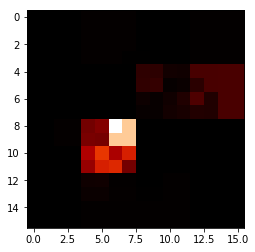

In [175]:
c = 0
sal_map = np.zeros((16, 16))
for i in range(16):
    for j in range(16):
        sal_map[i,j] = pi_predictive[c][(i,j)] 
        
plt.imshow(sal_map, interpolation = 'nearest', cmap = 'gist_heat')

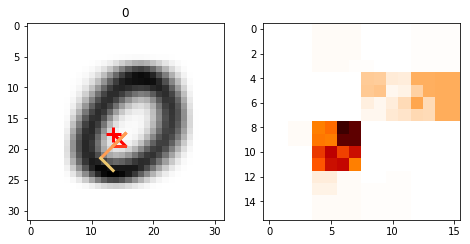

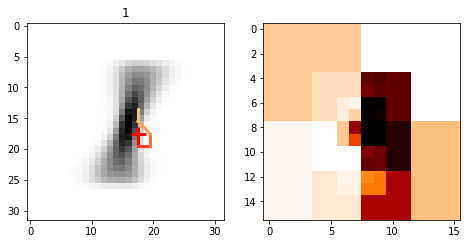

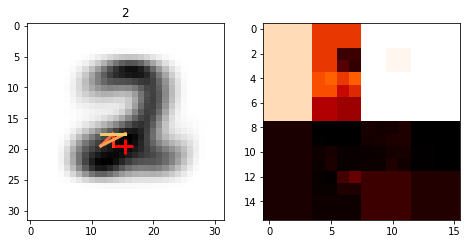

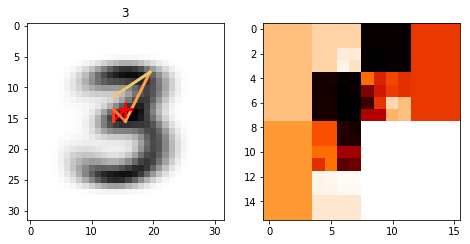

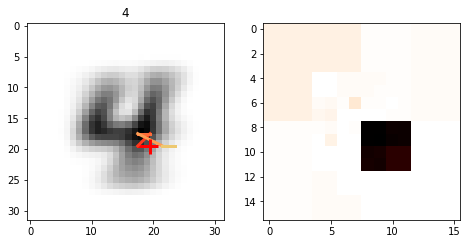

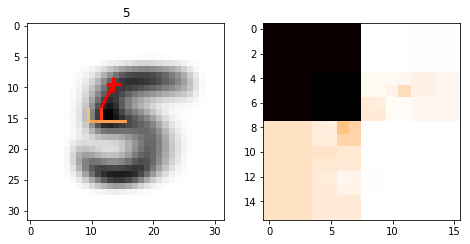

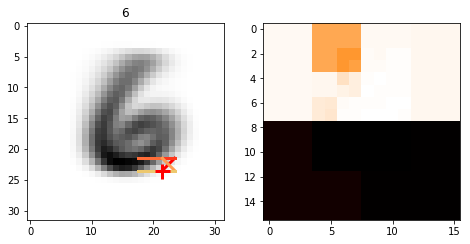

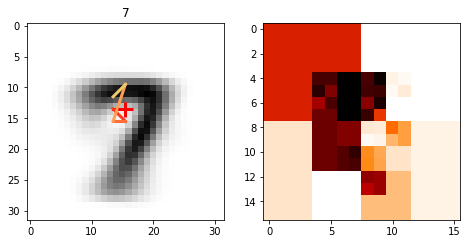

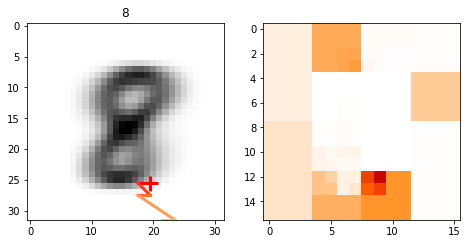

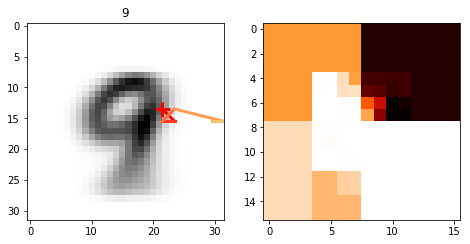

In [176]:
affiche_path(pi_predictive)

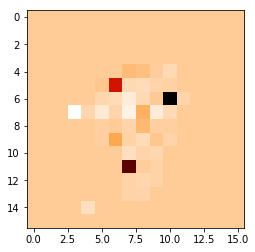

In [160]:
c = 9
sal_map = np.zeros((16, 16))
for i in range(16):
    for j in range(16):
        sal_map[i,j] = pi_predictive_eff[c][(i,j)] 
        
plt.imshow(sal_map, interpolation = 'nearest', cmap = 'gist_heat_r')

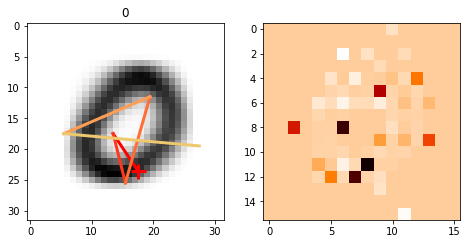

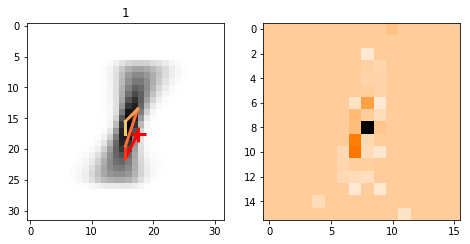

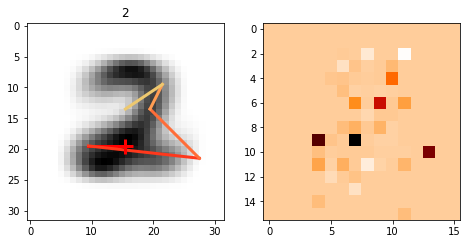

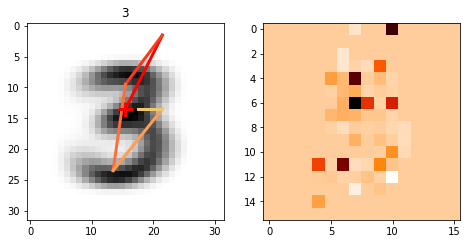

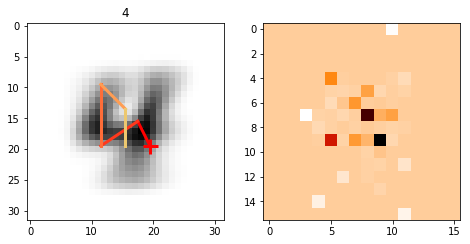

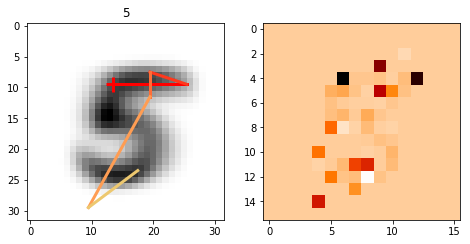

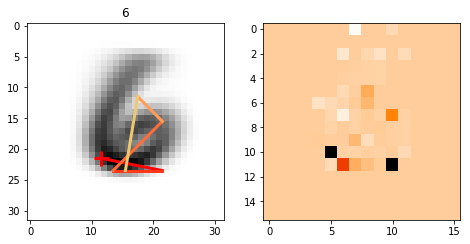

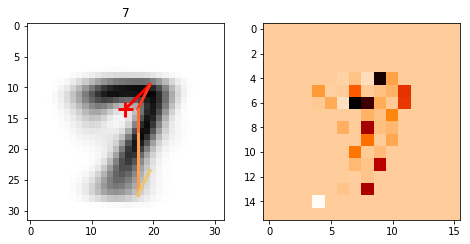

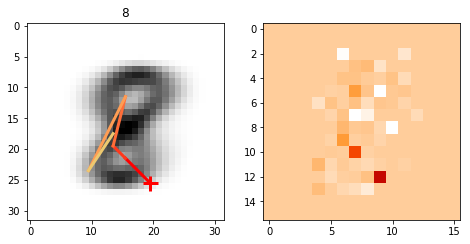

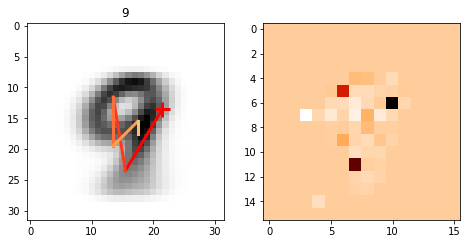

In [168]:
affiche_path(pi_predictive_eff)

#### Actual algorithm (see paper)

In [55]:
def prediction_based_policy(sess, log_score, actions_set, mem_h_u, batch_ref = None):
    
    ## 1 ##
    z_tilde = np.argmax(log_score)    
    u_tilde, _ = predictive_search(sess, z_tilde, actions_set, mem_h_u, batch_ref = batch_ref)
    
    return u_tilde

In [56]:
def saliency_based_policy(log_score, pi_predictive_sorted, mem_h_u):
    h_ref = h_max - 1
    z_tilde = np.argmax(log_score)
    u_tilde = pi_predictive_sorted[z_tilde].pop()[1]
    while (h_ref, u_tilde) in mem_h_u:
        u_tilde = pi_predictive_sorted[z_tilde].pop()[1]
    return u_tilde
    

In [57]:
def random_policy(log_score, mem_h_u):
    h_ref = h_max - 1
    ## 1 ##
    z_tilde = np.argmax(log_score)
    u_tilde = (np.random.randint(16),  np.random.randint(16))
    while (h_ref, u_tilde) in mem_h_u:
        u_tilde = (np.random.randint(16),  np.random.randint(16))
    return u_tilde

In [58]:
def scene_exploration(sess, test_tensor, z_ref, ind_test, log_score, actions_set, mem_h_u, record, \
                      POL = 'predictive', AFF = True, THRESHOLD = 1e-4):
    
    assert POL == 'predictive' or POL == 'saliency-based' or POL == 'random' or POL == 'full'
    
    if POL == 'full':
        THRESHOLD = 0
        POL = 'saliency-based'
    
    TOUR = 0
    END = False
    h_ref = h_max - 1
    
    # saliency-based approach
    if POL == 'saliency-based':
        pi_predictive_sorted = calc_pi_predictive_sorted(pi_predictive_eff)
    
    while END == False:
        
        if AFF:
            print '************************************'
            print '******       TOUR    ' + str(TOUR + 1) + '        ******'
            print '************************************'
        
        # 1. CHOIX
        if POL == 'predictive':
            u_tilde = prediction_based_policy(sess, log_score, actions_set, mem_h_u, batch_ref = test_tensor)
        elif POL == 'saliency-based':
            u_tilde = saliency_based_policy(log_score, pi_predictive_sorted, mem_h_u)
        else:
            u_tilde = random_policy(log_score, mem_h_u)
        
        if AFF:
            print 'CHOIX :', u_tilde
        
        # 2. LECTURE + UPDATE
        liste_path = calcule_asc_path(h_ref, u_tilde)
        
        for (h_path, u_path) in reversed(liste_path):
            if (h_path, u_path) not in mem_h_u:
                v = Data_test[z_ref][h_path][u_path][ind_test] 
                fill_test_tensor(v, h_path, u_path, test_tensor)
                
                #lik_path = calc_lik(v, h_path, u_path)
                #log_score = update_log_score(log_score, lik_path)
                log_score = sess.run(h_out, feed_dict={x: test_tensor,\
                                                            keep_prob: 1})
                pi = sess.run(tf.nn.softmax(MULT_FACTOR * log_score))[0]
                
                mem_h_u += [(h_path, u_path)]
                #pi = calc_pi(log_score)
                H = np.sum(- pi * np.log(pi))
                out = np.argmax(pi)
                
                if AFF :
                    print 'pi : ', pi
                    print 'out :', out
                    print 'pi[out] : ', pi[out]
                    print 'H : ', H
                
                record.mem_pi += [pi]
                record.mem_H += [H]
                record.mem_z += [out]
                record.mem_h_u += [(h_path, u_path)]
                record.nb_coeffs += 3
                
        # 3. INHIBITION OF RETURN        
        actions_set.pop(u_tilde)
        
        record.mem_u += [u_tilde]
        record.nb_saccades += 1
                
        if AFF:
            print '****', 'z :', z_ref, ', u :',u_tilde, ' ---> ', out
              
        #mem_u_final += [u]
        #mem_pi_copy += [list(mem_pi)]
        #mem_H_copy += [list(mem_H)]
        #mem_out += [out]
        #if TOUR == 50 or (TOUR >5 and pi[out] > .99999):   
        
        if TOUR == len(U[h_max - 1]) - 1 or H < THRESHOLD:
        #if TOUR == 50 or H < THRESHOLD:
            END = True
            if AFF :
                print '************************************'
                print '******         FINI          *******'
                print '************************************' 
            return out
            #mem_out_final += [out]
            #mem_turn += [TOUR]
        else:
            TOUR += 1
           
        

#### Single image exploration (+ record TODO) 

In [59]:
from record import Record            

#### Affichage

In [60]:
from record import affiche_records   

#### Main

In [61]:
NB_CLASSES = 10
NB_TRIALS = 100
MULT_FACTOR = 20

In [63]:
import time
dict_records = {}

for POL in ('predictive',) :#, 'saliency-based', 'random'):
    
    dict_records[POL] = {}
    
    for THRESHOLD in (1e-1, 1e-2, 1e-3, 1e-4, 1e-5):
        
        records = [] 
        cpt_TRIALS = 0
        
        for z_ref in range(NB_LABEL):
            tic = time.time()
            
            #NB_TRIALS = len(Data_test[z_ref][0][(0,0)])
            
            for ind_test in range(NB_TRIALS):
                
                test_tensor = init_test_tensor(BATCH_SIZE = 1)

                # initial
                log_score = np.zeros(10)
                pi = np.ones(10) / 10
                H = np.sum(- pi * np.log(pi))

                record = Record()
                record.POL = POL
                record.THRESHOLD = THRESHOLD
                record.z_ref = z_ref
                record.mem_pi += [pi]
                record.mem_H += [H]

                # global coef --> log_score initial
                h, u = 0, (0, 0)
                mem_h_u = [(h, u)]
                v = Data_test[z_ref][h][u][ind_test]
                fill_test_tensor(v, h, u, test_tensor)
                log_score = sess.run(h_out, feed_dict={x: test_tensor,\
                                                        keep_prob: 1})
                pi = sess.run(tf.nn.softmax(MULT_FACTOR * log_score))[0]
                H = np.sum(- pi * np.log(pi))
                z_tilde = np.argmax(pi)

                record.mem_pi += [pi]
                record.mem_H += [H]
                record.mem_z += [z_tilde]
                record.nb_coeffs += 1

                # initial actions set
                actions_set = {}
                for i in range(16):
                    for j in range(16):
                        actions_set[(i, j)] = 1

                z_final = scene_exploration(sess, test_tensor, z_ref, ind_test, log_score,\
                                            actions_set, mem_h_u, record, \
                                            POL = POL, AFF = False, THRESHOLD = THRESHOLD)
                record.z_final = z_final
                record.success = z_ref == z_final

                records += [record]
                
            toc = time.time()
            print '\rPolicy : %s, threshold : %g, classe %d, step %d, rep : %d, elapsed time : %g' \
                                % (POL, THRESHOLD, z_ref, ind_test, z_final, toc - tic)   
            cpt_TRIALS  += NB_TRIALS

        dict_records[POL][THRESHOLD] = records
        print '\n'
        print 'Nb trials :', cpt_TRIALS
        #affiche_records(records)
        print '\n'
        np.save('mnist-waveimage-FCNN-records-predictive', dict_records)
        

Policy : predictive, threshold : 0.1, classe 0, step 99, rep : 6, elapsed time : 54.7525
Policy : predictive, threshold : 0.1, classe 1, step 99, rep : 8, elapsed time : 3327.07
Policy : predictive, threshold : 0.1, classe 2, step 99, rep : 2, elapsed time : 177.152
Policy : predictive, threshold : 0.1, classe 3, step 99, rep : 3, elapsed time : 335.846
Policy : predictive, threshold : 0.1, classe 4, step 99, rep : 1, elapsed time : 406.958
Policy : predictive, threshold : 0.1, classe 5, step 99, rep : 7, elapsed time : 468.177
Policy : predictive, threshold : 0.1, classe 6, step 99, rep : 6, elapsed time : 427.418
Policy : predictive, threshold : 0.1, classe 7, step 99, rep : 7, elapsed time : 504.772
Policy : predictive, threshold : 0.1, classe 8, step 99, rep : 8, elapsed time : 959.93
Policy : predictive, threshold : 0.1, classe 9, step 99, rep : 9, elapsed time : 771.224


Nb trials : 1000


Policy : predictive, threshold : 0.01, classe 0, step 99, rep : 6, elapsed time : 1205.13


KeyboardInterrupt: 

[(12, 9), (11, 4), (5, 5)]


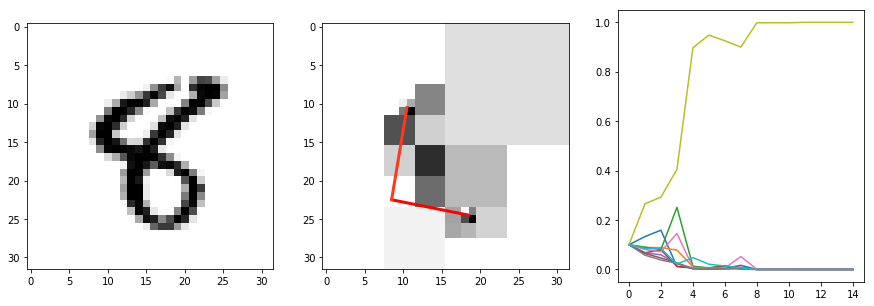

In [218]:
w_all = WaveImage()

for h in U:
    for u in U[h]:
        w_all.set_data(h,u,Data_test[z_ref][h][u][ind_test])

w_aff = WaveImage()
for (h,u) in record.mem_h_u :
    w_aff.set_data(h,u,Data_test[z_ref][h][u][ind_test])

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(w_all.get_image(), interpolation='nearest', cmap='gray_r')

plt.subplot(1,3,2)
plt.imshow(w_aff.get_image(), interpolation='nearest', cmap='gray_r')

path_i, path_j = [], []
for u in record.mem_u :
    path_i += [u[0] * 2 + 0.5]
    path_j += [u[1] * 2 + 0.5]

affiche_path_mnist(path_i, path_j)
print record.mem_u[:10]

plt.subplot(1,3,3)
f = plt.plot(record.mem_pi)


In [145]:
U

{0: {(0, 0): 1},
 1: {(0, 0): 1},
 2: {(0, 0): 1, (0, 1): 1, (1, 0): 1, (1, 1): 1},
 3: {(0, 0): 1,
  (0, 1): 1,
  (0, 2): 1,
  (0, 3): 1,
  (1, 0): 1,
  (1, 1): 1,
  (1, 2): 1,
  (1, 3): 1,
  (2, 0): 1,
  (2, 1): 1,
  (2, 2): 1,
  (2, 3): 1,
  (3, 0): 1,
  (3, 1): 1,
  (3, 2): 1,
  (3, 3): 1},
 4: {(0, 0): 1,
  (0, 1): 1,
  (0, 2): 1,
  (0, 3): 1,
  (0, 4): 1,
  (0, 5): 1,
  (0, 6): 1,
  (0, 7): 1,
  (1, 0): 1,
  (1, 1): 1,
  (1, 2): 1,
  (1, 3): 1,
  (1, 4): 1,
  (1, 5): 1,
  (1, 6): 1,
  (1, 7): 1,
  (2, 0): 1,
  (2, 1): 1,
  (2, 2): 1,
  (2, 3): 1,
  (2, 4): 1,
  (2, 5): 1,
  (2, 6): 1,
  (2, 7): 1,
  (3, 0): 1,
  (3, 1): 1,
  (3, 2): 1,
  (3, 3): 1,
  (3, 4): 1,
  (3, 5): 1,
  (3, 6): 1,
  (3, 7): 1,
  (4, 0): 1,
  (4, 1): 1,
  (4, 2): 1,
  (4, 3): 1,
  (4, 4): 1,
  (4, 5): 1,
  (4, 6): 1,
  (4, 7): 1,
  (5, 0): 1,
  (5, 1): 1,
  (5, 2): 1,
  (5, 3): 1,
  (5, 4): 1,
  (5, 5): 1,
  (5, 6): 1,
  (5, 7): 1,
  (6, 0): 1,
  (6, 1): 1,
  (6, 2): 1,
  (6, 3): 1,
  (6, 4): 1,
  (6, 5): 1,

In [ ]:
print test_tensor[0][:10]

In [ ]:
test = h_out.eval(feed_dict={ x: test_tensor,\
                                    keep_prob: 1})

print sess.run(tf.nn.softmax(test))

In [ ]:
record.mem_pi

In [ ]:
import time

POL = 'full'
    
dict_records[POL] = {}
    
THRESHOLD = 1

records = [] 
cpt_TRIALS = 0

for z_ref in range(NB_CLASSES):
    tic = time.time()

    NB_TRIALS = len(Data_test[z_ref][0][(0,0)])

    for ind_test in range(NB_TRIALS):

        # initial
        log_score = np.zeros(10)
        pi = np.ones(10) / 10
        H = np.sum(- pi * np.log(pi))

        record = Record()
        record.POL = POL
        record.THRESHOLD = THRESHOLD
        record.z_ref = z_ref
        record.mem_pi += [pi]
        record.mem_H += [H]

        # global coef --> log_score initial
        h, u = 0, (0, 0)
        mem_h_u = [(h, u)]
        v = Data_test[z_ref][h][u][ind_test]
        lik = calc_lik(v,h,u)
        log_score = update_log_score(log_score, lik)
        pi = calc_pi(log_score)
        H = np.sum(- pi * np.log(pi))
        z_tilde = np.argmax(log_score)

        record.mem_pi += [pi]
        record.mem_H += [H]
        record.mem_z += [z_tilde]
        record.nb_coeffs += 1

        # initial actions set
        actions_set = {}
        for i in range(16):
            for j in range(16):
                actions_set[(i, j)] = 1

        z_final = scene_exploration(z_ref, ind_test, log_score, actions_set, mem_h_u, record, \
                                    POL = POL, AFF = False, THRESHOLD = THRESHOLD)
        record.z_final = z_final
        record.success = z_ref == z_final

        records += [record]

        #sys.stdout.write('\rPolicy : %s, threshold : %g, classe %d, step %d, rep : %d' \
        #                     % (POL, THRESHOLD, z_ref, ind_test, z_final)) 
        #sys.stdout.flush()

    toc = time.time()
    print '\rPolicy : %s, threshold : %g, classe %d, step %d, rep : %d, elapsed time : %g' \
                        % (POL, THRESHOLD, z_ref, ind_test, z_final, toc - tic)   
    cpt_TRIALS  += NB_TRIALS

dict_records[POL][THRESHOLD] = records
print '\n'
print 'Nb trials :', cpt_TRIALS
affiche_records(records)
print '\n'
np.save('mnist-waveimage-FCNN-records', dict_records)
        